<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

<img title="Moby Bikes" src="https://i.ytimg.com/vi/-s8er6tHD3o/maxresdefault.jpg" style="height:400px; border-radius: 10px" alt="Moby Bikes" class="img-fluid">

<div class="list-group" id="list-tab" role="tablist">
  <h1 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">&nbsp;Contents:</h1>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#1" role="tab" aria-controls="profile">1. Introduction<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#2" role="tab" aria-controls="messages">2. Feature Engineering<span class="badge badge-primary badge-pill">2</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#3" role="tab" aria-controls="messages">3. EDA (Exploratory Data Analysis)<span class="badge badge-primary badge-pill">3</span></a>
   <a class="list-group-item list-group-item-action" data-toggle="list" href="#4" role="tab" aria-controls="messages">4. Model<span class="badge badge-primary badge-pill">4</span></a>
   <a class="list-group-item list-group-item-action" data-toggle="list" href="#5" role="tab" aria-controls="messages">5. Evaluation<span class="badge badge-primary badge-pill">5</span></a>    
   <a class="list-group-item list-group-item-action" data-toggle="list" href="#6" role="tab" aria-controls="messages">6. Conclusion<span class="badge badge-primary badge-pill">6</span></a>
</div>

---
# <p style="font-size:100%; text-align:left; color:#444444;">Contents:</p>

* [1. Introduction](#1)
* [2. Feature Engineering](#2)
    * [2.1 Date features](#2.1)
    * [2.2 Battery](#2.2)
    * [2.3 Rental](#2.3)
    * [2.4 Geolocation](#2.4)
* [3. EDA](#3)
* [4. Model](#4)
    * [4.1 Regression](#4.1)
    * [4.2 Ensemble](#4.2)
* [5. Evaluation](#5)
* [6. Evaluation](#6)

<a id="1"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">1- Introduction</p>

## Datasets

Dataset provided by [Moby Bikes](https://data.gov.ie/dataset/moby-bikes) through a public [API](https://data.smartdublin.ie/mobybikes-api). 

Dataset provided by [Met Éireann](https://www.met.ie/) through a public [API](https://data.gov.ie/organization/meteireann). 


The **aim** of this report is to map how this disease spread throughout the island and provide insights on possible spots and species that might need extra attention from the scientists who investigate this constant threat to resident birds.

## Questions

- What species have shown to be the most affected with Bird Flu?
- What are the most frequent locations where captured birds have been detected with Avian Flu?
- November is the month with the highest presence as mentioned? What are the months with the highest proportion of infected birds?
- The percentage of infected birds have increased during the years?
- What is the proportion of birds targeted with Avian Flu on each Council / County?
- Which areas present statistically significant incidence of Bird Flu?


>https://mobidev.biz/blog/machine-learning-methods-demand-forecasting-retail

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

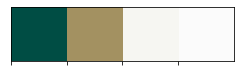

In [11]:
sns.palplot(['#004D44','#A39161','#F6F6F2','#FBFBFB'])

In [12]:
from conn import mongodb
import importlib
from pymongo import MongoClient
from urllib.parse import quote_plus
importlib.reload(mongodb)

<module 'conn.mongodb' from '/Users/pessini/Dropbox/Data-Science/moby-bikes/notebooks/conn/mongodb.py'>

In [35]:
def _connect_mongo(host, port, username, password, db_name):
    """ A util for making a connection to mongo """

    if username and password:
        try:
            mongo_uri = f'mongodb://{username}:{quote_plus(password)}@{host}:{port}/{db_name}'
            conn = MongoClient(mongo_uri)
        except:
            print('Could not connect to MongoDB')
    else:
        conn = MongoClient(host, port)

    return conn

In [67]:
def read_mongo(query={}, collection='', no_id=True):
    """ Read from Mongo and Store into a DataFrame """
    df = None
    try:
        # Connect to MongoDB
        conn = _connect_mongo(host=mongodb.host, port=mongodb.port, username=mongodb.user_name, password=mongodb.pass_word, db_name=mongodb.db_name)
        db = conn.mobybikes # switch to the database

        if collection in db.list_collection_names():
            
            # Make a query to the specific DB and Collection and store into a Dataframe
            data = db[collection].find(query)
            df =  pd.DataFrame(list(data))
            
            # Delete the _id
            if no_id:
                del df['_id']
        else:
            print(f'Collection {collection} was not found!')
            pass

        # close mongodb connection
        conn.close()
    except:
        print('Could not query MongoDB')
    
    return df


In [79]:
# from bson.objectid import ObjectId

# query = {
#     '_id': ObjectId('60f71005df6b1188a680219b')
# }

historical_data = read_mongo(collection='historical')

In [80]:
historical_data.columns = historical_data.columns.str.lower()
historical_data.head()

,HarvestTime,BikeID,Battery,EBikeStateID,LastGPSTime,LastRentalStart,Latitude,Longitude
0,2021-04-01 00:00:03,5,7.0,2,2021-03-31 23:41:40,2021-03-30 19:18:18,53.3091,-6.21643
1,2021-04-01 00:00:03,6,16.0,2,2021-03-31 23:55:41,2021-03-31 10:31:13,53.3657,-6.32249
2,2021-04-01 00:00:03,7,66.0,2,2021-03-31 23:42:04,2021-03-30 13:07:19,53.2799,-6.14497
3,2021-04-01 00:00:03,8,48.0,2,2021-03-31 23:52:26,2021-03-30 12:43:17,53.2891,-6.11378
4,2021-04-01 00:00:03,9,-6.0,2,2021-03-31 23:50:20,2021-03-29 22:37:58,53.2928,-6.13014


In [82]:
historical_data.isnull().sum()

HarvestTime            0
BikeID                 0
Battery            25342
EBikeStateID           0
LastGPSTime            0
LastRentalStart        0
Latitude               0
Longitude              0
dtype: int64

<a id="2"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">2- Feature Engineering</p>

### New Features
- date (yyyy-mm-dd)
- month
- hour
- workingday
- holiday
- season
- battery_start
- battery_end
- path? (multi polygon)
- rental_duration


The number of rentals will be aggregate later with a new feature *count*.

groupby('LocationID').size().sort_values(ascending=False)

In [299]:
rentals_data = historical_data.drop(['harvesttime','ebikestateid'], axis=1).copy()
rentals_data[["lastgpstime", "lastrentalstart"]] = rentals_data[["lastgpstime", "lastrentalstart"]].apply(pd.to_datetime)

In [300]:
rentals_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960928 entries, 0 to 960927
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   bikeid           960928 non-null  int64         
 1   battery          935586 non-null  float64       
 2   lastgpstime      960928 non-null  datetime64[ns]
 3   lastrentalstart  960928 non-null  datetime64[ns]
 4   latitude         960928 non-null  float64       
 5   longitude        960928 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 44.0 MB


In [301]:
def feat_eng(x):
    d = {}
    d['coordinates'] = x[['latitude','longitude']].values.tolist()
    d['start_battery'] = list(x['battery'])[-1] # get the first battery status (when rental started)
    d['lastgpstime'] = list(x['lastgpstime'])[0] # get the last gpstime (previously sorted)
    
    return pd.Series(d, index=['coordinates', 'start_battery', 'lastgpstime'])

grouped_rentals = rentals_data.sort_values("lastgpstime", ascending=False).groupby(['lastrentalstart', 'bikeid']).apply(feat_eng).reset_index()

In [302]:
grouped_rentals.shape

(27534, 5)

In [303]:
grouped_rentals['rental_date'] = grouped_rentals['lastrentalstart'].dt.date
grouped_rentals['rental_month'] = grouped_rentals['lastrentalstart'].dt.month
grouped_rentals['rental_hour'] = grouped_rentals['lastrentalstart'].dt.hour

# holiday
# working day
# season

grouped_rentals['duration'] = abs((grouped_rentals['lastrentalstart'] - grouped_rentals['lastgpstime']) / pd.Timedelta(minutes=1))

In [320]:
grouped_rentals.head()

,lastrentalstart,bikeid,coordinates,start_battery,lastgpstime,rental_date,rental_month,rental_hour,duration
0,2020-09-16 10:20:24,48,"[[53.3557, -6.25758], [53.3558, -6.25758], [53...",65.0,2020-09-25 14:46:48,2020-09-16,9,10,13226.400000
1,2020-09-18 12:43:04,74,"[[53.2981, -6.16029], [53.2981, -6.16026], [53...",65.0,2020-09-24 09:20:39,2020-09-18,9,12,8437.583333
2,2020-09-18 22:37:39,121,"[[53.2948, -6.13358], [53.2948, -6.13357], [53...",70.0,2020-09-23 18:30:39,2020-09-18,9,22,6953.000000
3,2020-09-19 18:46:36,83,"[[53.3424, -6.23761], [53.3432, -6.23872], [53...",75.0,2020-09-28 14:33:28,2020-09-19,9,18,12706.866667
4,2020-09-21 12:46:59,56,"[[53.3331, -6.2432], [53.3331, -6.2432], [53.3...",80.0,2020-09-27 13:26:00,2020-09-21,9,12,8679.016667


In [305]:
grouped_rentals.isnull().sum()

lastrentalstart      0
bikeid               0
coordinates          0
start_battery      571
lastgpstime          0
rental_date          0
rental_month         0
rental_hour          0
duration             0
dtype: int64

In [310]:
grouped_rentals[grouped_rentals['start_battery'] > 100]

,lastrentalstart,bikeid,coordinates,start_battery,lastgpstime,rental_date,rental_month,rental_hour,duration
18592,2021-04-03 12:40:00,103,"[[53.3405, -6.2679]]",268.0,2021-04-03 12:55:11,2021-04-03,4,12,15.183333


From the battery records there is a few cases that we can consider. Only one record has `> 100` and a few negatives ones. To simplify the analysis the records will be normalized with values between `0 > x > 100`.

All missing values (*n=571*) will not be transformed as it could be only malfunction issue when transmiting the data and it could mislead the analysis.

In [314]:
# normalize battery status between 0 > x < 100
grouped_rentals['start_battery'] = abs(grouped_rentals['start_battery'])
grouped_rentals.loc[grouped_rentals['start_battery'] > 100, 'start_battery'] = 100


<AxesSubplot:xlabel='start_battery', ylabel='Density'>

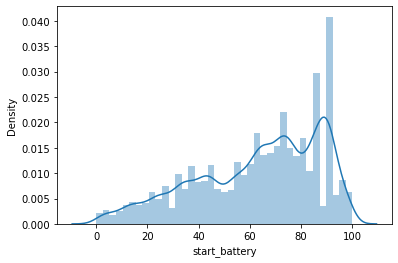

In [319]:
sns.distplot(grouped_rentals['start_battery'], label='Battery Distribution')

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini